In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import transformers

/home/kkerstin/.conda/envs/AI_final/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.__version__

'2.3.0+cu121'

In [4]:
config = {
    'model_name': 'bert-base-chinese',
    'epoch': 20,
    'batch_size': 32,
    'lr': 1e-5,
    'seed': 1234,
    'maxlen': 500,  # None 100
    'dropout': 0.5,
}

In [5]:
random.seed(config['seed'])
np.random.seed(config['seed'])
torch.manual_seed(config['seed'])

In [7]:
dir_path = '/home/kkerstin/Final_IntroAI/BERT/archive/'
data_dict = {
    'chnsenticorp': {
        'test': pd.read_csv(dir_path + 'ChnSentiCorp/ChnSentiCorp/test.csv', sep=',', header=0),
        'dev': pd.read_csv(dir_path + 'ChnSentiCorp/ChnSentiCorp/dev.csv', sep=',', header=0),
        'train': pd.read_csv(dir_path + 'ChnSentiCorp/ChnSentiCorp/train.csv', sep=',', header=0)
    }
}

In [8]:
data_dict['chnsenticorp']['train'].head()

,label,text_a
0,1,選擇珠江花園的原因就是方便，有電動扶梯直接到達海邊，周圍餐館、食廊、商場、超市、攤位一應俱全...
1,1,15.4寸筆記本的鍵盤確實爽，基本跟桌上型電腦差不多了，蠻喜歡數位小鍵盤，輸數位特方便，樣子...
2,0,房間太小。其他的都一般。。。。。。。。。
3,0,"1.接電源沒有幾分鐘,電源適配器熱的不行. 2.攝像頭用不起來. 3.機蓋的鋼琴漆，手不能摸..."
4,1,"今天才知道這書還有第6卷,真有點鬱悶:為什麼同一套書有兩種版本呢?當當網是不是該跟出版社商量..."


In [9]:
data_dict['chnsenticorp']['dev'].head()

,qid,label,text_a
0,0,1,"這間酒店環境和服務態度亦算不錯,但房間空間太小~~不宣容納太大件行李~~且房間格調還可以~~..."
1,1,1,"<薦書> 推薦所有喜歡<紅樓>的紅迷們一定要收藏這本書,要知道當年我聽說這本書的時候花很長時..."
2,2,0,商品的不足暫時還沒發現，京東的訂單處理速度實在.......週二就打包完成，週五才發貨...
3,3,1,２００１年來福州就住在這裡，這次感覺房間就了點，溫泉水還是有的．總的來說很滿意．早餐簡單了些．
4,4,1,不錯的上網本，外形很漂亮，作業系統應該是個很大的 賣點，電池還可以。整體上講，作為一個上網本...


In [10]:
data_dict['chnsenticorp']['test'].head()

,qid,text_a
0,0,這個賓館比較陳舊了，特價的房間也很一般。總體來說一般
1,1,懷著十分激動的心情放映，可是看著看著發現，在放映完畢後，出現一集米老鼠的動畫片！開始還懷疑是...
2,2,還稍微重了點，可能是硬碟大的原故，還要再輕半斤就好了。其他要進一步驗證。貼的幾種膜氣泡較多，...
3,3,交通方便；環境很好；服務態度很好 房間較小
4,4,不錯，作者的觀點很顛覆目前中國父母的教育方式，其實古人們對於教育已經有了很系統的體系了，可是...


In [11]:
tokenizer = transformers.BertTokenizer.from_pretrained(config['model_name'])

In [12]:
sentences = ["我喜欢芬芬，她太可爱了。", "我喜欢她的虎牙，笑起来真可爱！！！"]
inputs = tokenizer(sentences, max_length=15, truncation=True, padding='max_length', return_tensors='pt')
input_ids, token_type_ids, attention_mask = inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask']
print(inputs, '\n\n', input_ids, token_type_ids, attention_mask)

{'input_ids': tensor([[ 101, 2769, 1599, 3614, 5705, 5705, 8024, 1961, 1922, 1377, 4263,  749,
          511,  102,    0],
        [ 101, 2769, 1599, 3614, 1961, 4638, 5988, 4280, 8024, 5010, 6629, 3341,
         4696, 1377,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])} 

 tensor([[ 101, 2769, 1599, 3614, 5705, 5705, 8024, 1961, 1922, 1377, 4263,  749,
          511,  102,    0],
        [ 101, 2769, 1599, 3614, 1961, 4638, 5988, 4280, 8024, 5010, 6629, 3341,
         4696, 1377,  102]]) tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [13]:
class chnsenticorpDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        super(chnsenticorpDataset, self).__init__()
        self.labels = df.label.to_list()
        self.texts = df.text_a.to_list()
        inputs = tokenizer(
            self.texts,
            max_length=config['maxlen'],
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        self.input_ids, self.token_type_ids, self.attention_mask = inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask']
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.token_type_ids[idx], self.attention_mask[idx], torch.tensor(self.labels[idx])

In [14]:
train_dataset = chnsenticorpDataset(data_dict['chnsenticorp']['train'])
val_dataset = chnsenticorpDataset(data_dict['chnsenticorp']['dev'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config['batch_size'])

In [15]:
model = transformers.BertModel.from_pretrained(config['model_name'])
for name, param in model.named_parameters():
    print(name, param.size())

unfreeze_layers = ['layer.10', 'layer.11', 'pooler']
for name, param in model.named_parameters():
    param.requires_grad = False
    if unfreeze_layers is not None:
        for layer in unfreeze_layers:
            if layer in name:
                param.requires_grad = True
                break

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.size())

embeddings.word_embeddings.weight torch.Size([21128, 768])
embeddings.position_embeddings.weight torch.Size([512, 768])
embeddings.token_type_embeddings.weight torch.Size([2, 768])
embeddings.LayerNorm.weight torch.Size([768])
embeddings.LayerNorm.bias torch.Size([768])
encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
encoder.layer.0.attention.self.query.bias torch.Size([768])
encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
encoder.layer.0.attention.self.key.bias torch.Size([768])
encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
encoder.layer.0.attention.self.value.bias torch.Size([768])
encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
encoder.layer.0.attention.output.dense.bias torch.Size([768])
encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])
encoder.layer.0.attention.output.LayerNorm.bias torch.Size([768])
encoder.layer.0.intermediate.dense.weight torch.Size([3072, 768])
encoder.layer.0.inter

In [16]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=None):
        super(BertClassifier, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(config['model_name'])
        unfreeze_layers = ['layer.10', 'layer.11', 'pooler']
        for name, param in self.bert.named_parameters():
            param.requires_grad = False
            for layer in unfreeze_layers:
                if layer in name:
                    param.requires_grad = True
                    break
        self.dropout = dropout
        self.linear = nn.Linear(768, 2)

    def forward(self, input_ids, token_type_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=False)[1]
        if self.dropout is not None:
            output = F.dropout(output, p=self.dropout, training=self.training)
        output = self.linear(output)
        output = F.softmax(output, dim=1)
        return output

In [17]:
model = BertClassifier(dropout=config['dropout'])

In [18]:
epochs = config['epoch']
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=config['lr'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [17]:
total_loss = []
total_acc = []
for epoch_num in range(epochs):

    model.train()
    total_loss_train = 0
    total_acc_train = 0
    for input_ids, token_type_ids, attention_mask, label in train_loader:
        input_ids = input_ids.to(device)
        token_type_ids = token_type_ids.to(device)
        attention_mask = attention_mask.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        loss = criterion(outputs, label)
        total_loss_train += loss.item()
        acc_num = (outputs.argmax(1) == label).sum()
        total_acc_train += acc_num
        loss.backward()
        optimizer.step()

    model.eval()
    total_loss_val = 0
    total_acc_val = 0
    with torch.no_grad():
        for input_ids, token_type_ids, attention_mask, label in val_loader:
            input_ids = input_ids.to(device)
            token_type_ids = token_type_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            loss = criterion(outputs, label)
            total_loss_val += loss.item()
            acc_num = (outputs.argmax(1) == label).sum()
            total_acc_val += acc_num

    print(
        "Epoch: [{:0>2d} / {:0>2d}] | Train Loss: {:.4f} | Val Loss: {:.4f} | Train Acc: {:.4f} | Val Acc: {:.4f}".format(
            epoch_num + 1,
            epochs,
            total_loss_train / len(train_dataset),
            total_loss_val / len(val_dataset),
            total_acc_train / len(train_dataset),
            total_acc_val / len(val_dataset)
        )
    )
    total_loss.append([total_loss_train / len(train_dataset), total_loss_val / len(val_dataset)])
    total_acc.append([(total_acc_train / len(train_dataset)).cpu().item(), (total_acc_val / len(val_dataset)).cpu().item()])

torch.save(model.state_dict(), 'model.pth')

Epoch: [01 / 20] | Train Loss: 0.0160 | Val Loss: 0.0134 | Train Acc: 0.8038 | Val Acc: 0.8917
Epoch: [02 / 20] | Train Loss: 0.0127 | Val Loss: 0.0129 | Train Acc: 0.9085 | Val Acc: 0.9058
Epoch: [03 / 20] | Train Loss: 0.0123 | Val Loss: 0.0127 | Train Acc: 0.9216 | Val Acc: 0.9067
Epoch: [04 / 20] | Train Loss: 0.0121 | Val Loss: 0.0124 | Train Acc: 0.9252 | Val Acc: 0.9242
Epoch: [05 / 20] | Train Loss: 0.0119 | Val Loss: 0.0128 | Train Acc: 0.9303 | Val Acc: 0.9100
Epoch: [06 / 20] | Train Loss: 0.0118 | Val Loss: 0.0122 | Train Acc: 0.9345 | Val Acc: 0.9292
Epoch: [07 / 20] | Train Loss: 0.0117 | Val Loss: 0.0121 | Train Acc: 0.9399 | Val Acc: 0.9275
Epoch: [08 / 20] | Train Loss: 0.0115 | Val Loss: 0.0121 | Train Acc: 0.9463 | Val Acc: 0.9317
Epoch: [09 / 20] | Train Loss: 0.0114 | Val Loss: 0.0120 | Train Acc: 0.9485 | Val Acc: 0.9350
Epoch: [10 / 20] | Train Loss: 0.0113 | Val Loss: 0.0120 | Train Acc: 0.9507 | Val Acc: 0.9358
Epoch: [11 / 20] | Train Loss: 0.0112 | Val Loss: 

In [19]:
total_loss = np.array(total_loss, dtype=np.float32)
total_acc = np.array(total_acc, dtype=np.float32)

NameError: name 'total_loss' is not defined

NameError: name 'total_loss' is not defined

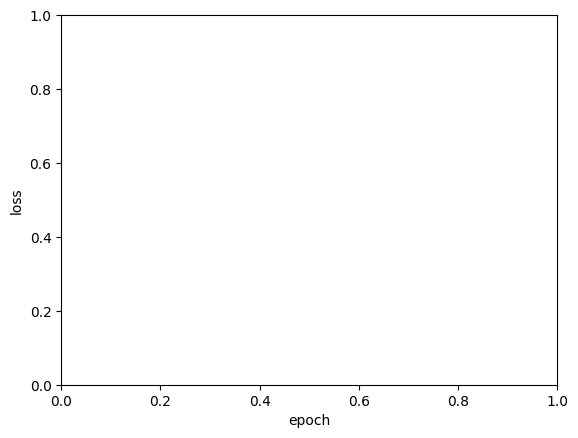

In [20]:
plt.figure()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(total_loss[:,0], 'b-', label="train")
plt.plot(total_loss[:,1], 'r-', label="val")
plt.legend()
plt.grid(True)
plt.show()

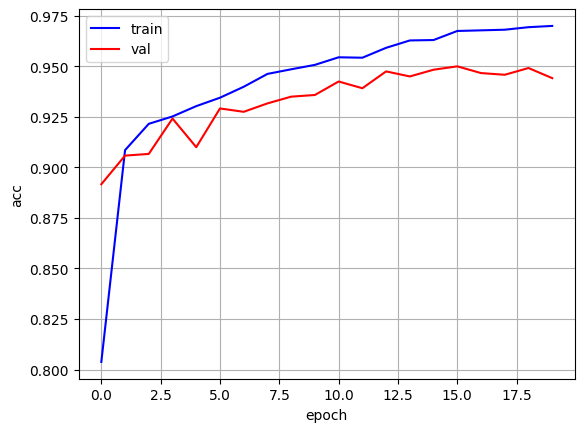

In [20]:
plt.figure()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.plot(total_acc[:,0], 'b-', label="train")
plt.plot(total_acc[:,1], 'r-', label="val")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
import os
import csv

# 載入訓練好的模型
model = BertClassifier(dropout=config['dropout'])
model.load_state_dict(torch.load('model.pth'))
model.eval()

# ------------------更改此處------------------
# 資料夾路徑
company_name = "聯電"
folder_path = f"/home/kkerstin/Final_IntroAI/BERT/news_data/{company_name}"

results = []

# 遍歷資料夾
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()
    
    inputs = tokenizer(
            text,
            max_length=config['maxlen'],
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    positive_score = outputs[:, 1].item()
    negative_score = outputs[:, 0].item()
    
    results.append([filename, positive_score, negative_score])

# 寫入CSV
output_filename = f"result_{company_name}.csv"
with open(output_filename, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["File Name", "Positive Score", "Negative Score"])
    writer.writerows(results)